# Lab 8 – Distances and PCA
#### Name: Matt McLaughlin 
#### Class: CSCI 349 - Intro to Data Mining 
#### Semester: 2020SP 
#### Instructor: Brian King

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.decomposition import PCA
#Things I had to import
from sklearn.preprocessing import MinMaxScaler
import scipy.spatial.distance as dist
import math
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

#### 1) [P] Set up a pandas data frame with the following 8 observations and 3 variables:
#### Be sure to set the types of each variable as follows:
#### • test1: Nominal, levels = { "A", "B", C" }
#### • test2: Ordinal, levels = { "poor", "fair", "good", "excellent" }
#### • test3: Numeric
#### Use pd.Categorical to properly set up categorical variables (i.e. test1 and test2) and pay attention to the ordered parameter. Name the data frame df. Set the index correctly to match the row names in the table above.
#### Display the df data frame, and then show the output of info() method to show the type of each variable in df .

In [2]:
index = ["A0", "A1", "A2", "A3", "A4", "A5", "A6", "A7"]
d1 = ["A","C","C","B","A", "B", "C", "B"]
d2 = ["excellent", "fair", "good",  "fair", "poor", "excellent", "good", "good"]
d3 = [25, 32, 60, 53, 23, 37, 45, 49]

d1_cat = pd.Categorical(values=d1, categories=["A","B","C"], ordered=True)
d2_cat = pd.Categorical(values=d2, categories=["poor", "fair", "good", "excellent"], ordered=True)

s1 = pd.Series(data=d1_cat,index=index,name="test1")
s2 = pd.Series(data=d2_cat, index=index, name="test2")
s3 = pd.Series(data=d3, index=index, name="test3")

d = {"test1":s1, "test2":s2, "test3":s3}
df = pd.DataFrame(d)
df

,test1,test2,test3
A0,A,excellent,25
A1,C,fair,32
A2,C,good,60
A3,B,fair,53
A4,A,poor,23
A5,B,excellent,37
A6,C,good,45
A7,B,good,49


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
test1    8 non-null category
test2    8 non-null category
test3    8 non-null int64
dtypes: category(2), int64(1)
memory usage: 440.0+ bytes


**2) [P] Show the output of df.describe(include='all'). What does the include='all' parameter
do?**

In [4]:
df.describe(include='all')

,test1,test2,test3
count,8,8,8.000000
unique,3,4,NaN
top,C,good,NaN
freq,3,3,NaN
mean,NaN,NaN,40.500000
std,NaN,NaN,13.416408
min,NaN,NaN,23.000000
25%,NaN,NaN,30.250000
50%,NaN,NaN,41.000000
75%,NaN,NaN,50.000000


#### Include=all will include all columns of the input in the output.

**3) [P] Show the output of df.test1.cat.categories, and df.test2.cat.categories. What is this
showing? Does it work for df.test3.cat.categories? (If not, then comment this line out.)**

In [5]:
df.test1.cat.categories

Index(['A', 'B', 'C'], dtype='object')

In [6]:
df.test2.cat.categories

Index(['poor', 'fair', 'good', 'excellent'], dtype='object')

In [7]:
#df.test3.cat.categories
print("It shows the order of the categories from least to greatest. It does not work for test3.")

It shows the order of the categories from least to greatest. It does not work for test3.


**4) [P] Show the output of df.test1.cat.codes, and df.test2.cat.codes. What is this showing?**

In [8]:
df.test1.cat.codes

A0    0
A1    2
A2    2
A3    1
A4    0
A5    1
A6    2
A7    1
dtype: int8

In [9]:
df.test2.cat.codes

A0    3
A1    1
A2    2
A3    1
A4    0
A5    3
A6    2
A7    2
dtype: int8

**5) [P] Report the counts of each level of the categorical variables.**

#### It shows the score or value of each cell. For example test1 A1 has "A". "C" is the least, so it equals 0. "A"=2. In test2 "excellent"=3. More succintly it is the **index value** of the item in the cell in the categorical list.

**6) [P] Report a cross tabulation (i.e. contingency table) between test1 and test2. Include the margins (i.e. the sum of the rows and the columns) in your reported table (HINT: Look up pandas crosstab() function)**

In [10]:
pd.crosstab(df.test1, df.test2, margins=True)

test2,poor,fair,good,excellent,All
test1,,,,,
A,1,0,0,1,2
B,0,1,1,1,3
C,0,1,2,0,3
All,1,2,3,2,8


**7) [P] From the previous table, store the contingency table without the margins in a variable called observed**

In [11]:
observed = pd.crosstab(df.test1, df.test2)
observed

test2,poor,fair,good,excellent
test1,,,,
A,1,0,0,1
B,0,1,1,1
C,0,1,2,0


**8) [P] Run a chi-squared test to determine whether test1 and test2 are dependent. Use the contingency table
from the previous step. Clearly report the chi2 statistic, the p value, and the degrees of freedom, and then use
the p-value to clearly state whether test1 and test2 are independent (assume p=0.05 threshold to test for independence)**

In [12]:
#Reference page
# https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.stats.chisquare.html 

#The reference describes the input as "Observed frequencies in each category" so I'm dividing count by total
chi_square = stats.chisquare(observed/observed.sum().sum())
print("The chi2 statisitc is " + str(chi_square[0]) + "\nand the p value is " + str(chi_square[1]))
print("With a p=0.05 threshold for independence, test1 and test2 are dependent.")

The chi2 statisitc is [0.25  0.125 0.25  0.125]
and the p value is [0.8824969  0.93941306 0.8824969  0.93941306]
With a p=0.05 threshold for independence, test1 and test2 are dependent.


**Now, you're going to explore some similarities between observations. Yes, this is a SMALL dataset! (Don't bother
to explore large data until you can understand how they work on small, toy experimental data!)**

**Before you can compute a pairwise distance matrix to report the distance between all pairs of observations,
always remember that you can only compute distances between strictly numeric data. Therefore, you must
convert your data to numeric types for ALL variables you want to include in your distance metric.**

**9) [P] Create a new data frame called df_num, that represents a numeric version of the above. Do NOT do any
rescaling of your variables yet!**

**NOTE: If you do this from a dataframe that has the categorical variables set up properly, then this step is
simple to do. The two choices I generally follow are either: 1) use the cat member of your categorical data,
which stores a CategoricalAccessor object (look it up), or use one of the encoders in the
sklearn.preprocessing module. The first option is easier, and yet another reason why it's so important
to take the time to preprocess your data as correctly and error-free as possible.**

**Your resulting data frame at the end of this step should be as follows:**

In [13]:
#df_num = df.apply(df.cat.codes, axis=1) #Wanted to do something like this but it isn't working
df_num = df.copy()
df_num['test1'] = df.test1.cat.codes
df_num['test2'] = df.test2.cat.codes
df_num

,test1,test2,test3
A0,0,3,25
A1,2,1,32
A2,2,2,60
A3,1,1,53
A4,0,0,23
A5,1,3,37
A6,2,2,45
A7,1,2,49


**10) [P] As you learned in lecture, you absolutely must rescale your data to fall on a similar scale. There are
different approaches to doing so. A standardized zscore is among the most common, but not necessarily
always the best approach, especially when you are dealing with numeric representations of true categorical
data. Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have
categorical data.**

**Let's first try to rescale our data to all fall between the values of 0 and 1. Use the MinMaxScaler in
sklearn.preprocessing to rescale all variables to fall between 0 and 1. Store the transformed data as a
pandas data frame called df_num_zeroone,. Your result should look as follows:**

In [14]:
scaler = MinMaxScaler() #Default is 0 to 1
scaler.fit(df_num)
df_num_zeroone = pd.DataFrame(scaler.transform(df_num), index=df.index, columns=df.columns)
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.054054
A1,1.0,0.333333,0.243243
A2,1.0,0.666667,1.000000
A3,0.5,0.333333,0.810811
A4,0.0,0.000000,0.000000
A5,0.5,1.000000,0.378378
A6,1.0,0.666667,0.594595
A7,0.5,0.666667,0.702703


**11) [P] Notice the value of test3. Quite often, when we have solid knowledge of what we expect our range to
be, then we can rescale our data using that knowledge. In the case of test3, you learned that the data must
fall between 0 and 100. Therefore, reassign test3 so that the min and max before rescaling are assuming to
be between 0 and 100, respectively. (i.e. simply divide the original variable by 100)**

In [15]:
df_num_zeroone.test3 = df_num.test3/100
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.25
A1,1.0,0.333333,0.32
A2,1.0,0.666667,0.60
A3,0.5,0.333333,0.53
A4,0.0,0.000000,0.23
A5,0.5,1.000000,0.37
A6,1.0,0.666667,0.45
A7,0.5,0.666667,0.49


**12) [P] Compute a single distance matrix called distmat_zeroone. Use a standard Euclidean distance
measure. Your reported result should be an 8x8 matrix with appropriately labeled rows and columns. (HINT –
study the output of the distance matrix functions! They do not output a square matrix. Look at the
squareform function. The pdist and squareform functions are in scipy.spatial.distance).**

In [16]:
def create_dist_mat(dataframe):
    temp_df = dist.pdist(dataframe) #Euclidean distance is default
    temp_df = dist.squareform(temp_df)
    temp_df = pd.DataFrame(temp_df, index=dataframe.index, columns=dataframe.index)
    return temp_df

In [17]:
distmat_zeroone = create_dist_mat(df_num_zeroone)
distmat_zeroone

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000000,1.203887,1.110680,0.879116,1.000200,0.514198,1.072898,0.647079
A1,1.203887,0.000000,0.435329,0.542310,1.057928,0.834832,0.357786,0.624509
A2,1.110680,0.435329,0.000000,0.604989,1.257515,0.643437,0.150000,0.511957
A3,0.879116,0.542310,0.604989,0.000000,0.671648,0.685598,0.606227,0.335725
A4,1.000200,1.057928,1.257515,0.671648,0.000000,1.126765,1.221820,0.872952
A5,0.514198,0.834832,0.643437,0.685598,1.126765,0.000000,0.606227,0.354275
A6,1.072898,0.357786,0.150000,0.606227,1.221820,0.606227,0.000000,0.501597
A7,0.647079,0.624509,0.511957,0.335725,0.872952,0.354275,0.501597,0.000000


**13) [P] Output the top three closest pairs of observations. You MUST write Python code to report these results! Do
not simply print out your distance matrix and tell me your answers! Consider that this may have been
thousands of observations! Always generate reported answers in code!**

**For each pair, output the pair of observations from the original dataframe, and the distance between them.**

In [18]:
def find_3_min(dist_df, th_ft=False):
    
    #Part 1
    dmz_temp = dist_df[dist_df.ne(0)].copy()

    name_arr1 = np.array(["  ","  ","  "])
    name_arr2 = np.array(["  ","  ","  "])

    dist_arr = np.array([math.inf, math.inf, math.inf])

    a_min = [dmz_temp.iloc[:,0].min(), dmz_temp.iloc[:,1].min(), dmz_temp.iloc[:,2].min(), dmz_temp.iloc[:,3].min(),\
             dmz_temp.iloc[:,4].min(), dmz_temp.iloc[:,5].min(), dmz_temp.iloc[:,6].min(), dmz_temp.iloc[:,7].min()]
    a_min_names = [dmz_temp.iloc[:,0].idxmin(), dmz_temp.iloc[:,1].idxmin(), dmz_temp.iloc[:,2].idxmin(), dmz_temp.iloc[:,3].idxmin(),\
                   dmz_temp.iloc[:,5].idxmin(), dmz_temp.iloc[:,6].idxmin(),dmz_temp.iloc[:,6].idxmin(),dmz_temp.iloc[:,7].idxmin()]

    min_ser = pd.Series(data=a_min, index=dist_df.index, name="Mins")
    min_name_ser = pd.Series(data=a_min_names, index=dist_df.index, name="Names")

    a_min_dict = {"Names":min_name_ser, "Mins":min_ser}

    df2 = pd.DataFrame(a_min_dict)
    
    #Part 2
    i = 0
    while name_arr1[2] == "  ":
        #The idea is that 3 times this will find the min, add it, add the names, then remove that entire row
        dist_arr[i] = df2.Mins.min()
        if not ((df2.Mins.idxmin() in name_arr1) or (df2.Mins.idxmin() in name_arr2)):#This should prevent us from adding [i,j], then [j,i]
            name_arr1[i] = df2.Mins.idxmin()
            name_arr2[i] = df2.Names[df2.Mins.idxmin()]
            i = i + 1
        df2.drop(df2.Mins.idxmin(), inplace=True)
        
        
    #Part 3
    for i in range(3):
        print("Closest #" + str(i) + "   " + str(name_arr1[i]) + " " + str(name_arr2[i])+ ", dist = " + str(dist_arr[i]) + '\n')
        if th_ft:
            temp_df = df.loc[ [name_arr1[i], name_arr2[i]] ,:]
            print(temp_df, '\n\n')

In [19]:
find_3_min(distmat_zeroone, True)

Closest #0   A2 A6, dist = 0.14999999999999997

   test1 test2  test3
A2     C  good     60
A6     C  good     45 


Closest #1   A3 A7, dist = 0.33572475498704457

   test1 test2  test3
A3     B  fair     53
A7     B  good     49 


Closest #2   A5 A2, dist = 0.35427547348230465

   test1      test2  test3
A5     B  excellent     37
A2     C       good     60 




**14) [P] Now, output the three most distant (least similar) pairs of observations. Again, for each pair, output the
two observations, and the distance between them.**

In [20]:
def find_3_max(dist_df, th_ft=False):
    #Part 1
    dmz_temp = dist_df.copy()

    name_arr1 = np.array(["  ","  ","  "])
    name_arr2 = np.array(["  ","  ","  "])

    dist_arr = np.array([-1.0, -1.0, -1.0]) #the .0 is necessary to make it float type, not int

    #Looking back, there was probably some fancy way to do this with apply
    a_max = [dmz_temp.iloc[:,0].max(), dmz_temp.iloc[:,1].max(), dmz_temp.iloc[:,2].max(), dmz_temp.iloc[:,3].max(),\
             dmz_temp.iloc[:,4].max(), dmz_temp.iloc[:,5].max(), dmz_temp.iloc[:,6].max(), dmz_temp.iloc[:,7].max()]
    a_max_names = [dmz_temp.iloc[:,0].idxmax(), dmz_temp.iloc[:,1].idxmax(), dmz_temp.iloc[:,2].idxmax(), dmz_temp.iloc[:,3].idxmax(),\
                   dmz_temp.iloc[:,5].idxmax(), dmz_temp.iloc[:,6].idxmax(),dmz_temp.iloc[:,6].idxmax(),dmz_temp.iloc[:,7].idxmax()]

    max_ser = pd.Series(data=a_max, index=df.index, name="Maxes")
    max_name_ser = pd.Series(data=a_max_names, index=df.index, name="Names")

    a_max_dict = {"Names":max_name_ser, "Maxes":max_ser}

    df3 = pd.DataFrame(a_max_dict)
    
    #Part 2
    i = 0
    while name_arr1[2] == "  ":
        #The idea is that 3 times this will find the max, add it, add the names, then remove that entire row
        dist_arr[i] = df3.Maxes.max()
        if not ((df3.Maxes.idxmax() in name_arr1) or (df3.Maxes.idxmax() in name_arr2)):#This should prevent us from adding [i,j], then [j,i]
            name_arr1[i] = df3.Maxes.idxmax()
            name_arr2[i] = df3.Names[df3.Maxes.idxmax()]
            i = i + 1
        df3.drop(df3.Maxes.idxmax(), inplace=True)
    
    
    #Part 3
    for i in range(3):
        print("Most Distant #" + str(i) + "   " + str(name_arr1[i]) + " " + str(name_arr2[i])+ ", dist = " + str(dist_arr[i]) + '\n')
        if th_ft:
            temp_df = df.loc[ [name_arr1[i], name_arr2[i]] ,:]
            print(temp_df, '\n\n')

In [21]:
find_3_max(distmat_zeroone, True)

Most Distant #0   A2 A4, dist = 1.2575151865661283

   test1 test2  test3
A2     C  good     60
A4     A  poor     23 


Most Distant #1   A6 A4, dist = 1.2218201358810732

   test1 test2  test3
A6     C  good     45
A4     A  poor     23 


Most Distant #2   A0 A1, dist = 1.2038872224774397

   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32 




**15) [P] Create a new data frame, df_num_binarized, that stores the a binarized version for test1 and test2.
For example, test1 has three distinct values, "A", "B", and "C". Therefore, you should end up with three
new variables that replace the one categorical variable. Best practice is to name your variables accordingly,
with the variable name prefix, and the value as a suffix, usually with an _ in between. Thus, your result for the
first variable should look like:**

**Do this for BOTH categorical variables test1, and test2. However, test3 is already numeric, and we
scaled it between zero-one already. Thus just copy the result of test3 from df_num_zeroone.
HINT - HOW? One approach is to use OneHotEncoder from sklearn.preprocessing. For this
purpose, you can set the parameter sparse=False so that you can easily view the data, and set your
dtype=int.
Your result should look something like the following:**
**Another approach is to use the pandas function get_dummies().**

In [22]:
#Use pd.get_dummies, not OneHotEncoder

pre = ["test1", "test2"]
df_num_binarized = pd.get_dummies(data=df.loc[:,["test1","test2"]], prefix=pre)
df_num_binarized["test3"] = df_num_zeroone.test3

df_num_binarized

,test1_A,test1_B,test1_C,test2_poor,test2_fair,test2_good,test2_excellent,test3
A0,1,0,0,0,0,0,1,0.25
A1,0,0,1,0,1,0,0,0.32
A2,0,0,1,0,0,1,0,0.60
A3,0,1,0,0,1,0,0,0.53
A4,1,0,0,1,0,0,0,0.23
A5,0,1,0,0,0,0,1,0.37
A6,0,0,1,0,0,1,0,0.45
A7,0,1,0,0,0,1,0,0.49


**16) [P] Now, compute distmat_binarized by computing the distance matrix for the df_binarized.**

In [23]:
distmat_binarized = create_dist_mat(df_num_binarized)
distmat_binarized

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000000,2.001225,2.030394,2.019505,1.414355,1.419296,2.009975,2.014349
A1,2.001225,0.000000,1.441666,1.429720,2.002024,2.000625,1.420176,2.007212
A2,2.030394,1.441666,0.000000,2.001225,2.033937,2.013182,0.150000,1.418485
A3,2.019505,1.429720,2.001225,0.000000,2.022375,1.423236,2.001599,1.414779
A4,1.414355,2.002024,2.033937,2.022375,0.000000,2.004894,2.012064,2.016829
A5,1.419296,2.000625,2.013182,1.423236,2.004894,0.000000,2.001599,1.419296
A6,2.009975,1.420176,0.150000,2.001599,2.012064,2.001599,0.000000,1.414779
A7,2.014349,2.007212,1.418485,1.414779,2.016829,1.419296,1.414779,0.000000


**17) [P] Report the three closest pairs, and the three most distant pairs from distmat_binarized**

In [24]:
#I went back and turned #13 and #14 into functions. Yay me.
find_3_min(distmat_binarized)

Closest #0   A2 A6, dist = 0.14999999999999997

Closest #1   A0 A4, dist = 1.4143549766589716

Closest #2   A3 A7, dist = 1.4147791347061915



In [25]:
find_3_max(distmat_binarized)

Most Distant #0   A2 A4, dist = 2.033937068839643

Most Distant #1   A0 A2, dist = 2.0303940504246953

Most Distant #2   A3 A4, dist = 2.0223748416156684



**18) [M] Take a moment and compare and contrast your results. Which method do you think have the better
results? Why? Which variable do you think was the distinguishing player in affecting the different outcomes
between both of the above approaches to transforming your data to numeric results? Why? Summarize what
would have been the best transformation to make for all three variables that would have given the most
accurate results.**

#### distmat_zeroone vs distmat_binarized:
#### 

**19) [P] Load in your next dataset using the following:
df_car_crashes = sns.load_dataset('car_crashes')**

In [26]:
df_car_crashes = sns.load_dataset('car_crashes')

**The dataset is directly downloaded from: https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv**

**Figure out what this dataset is all about. Sometimes, it's easy to figure out. Just Google! And, sometimes we
find interesting publicly available data but we need to make the best guess regarding our variables. For now,
don't worry too much about specifics. This is a very simplified, highly aggregated dataset from much more
extensive statistics drawn from the Insurance Institute for Highway Safety -
https://www.iihs.org/iihs/topics/t/general-statistics/fatalityfacts/state-by-state-overview (NOTE - this might
make a great repository for some project?)**

**20) [P] Preprocess your data. Minimally, you should move the state code to become the index for the dataframe,
and then drop that column from your dataframe. Show the first five rows.**

In [27]:
df_car_crashes.index = df_car_crashes.abbrev
df_car_crashes = df_car_crashes.iloc[:,range(7)]

df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


**21) [P] Create a new dataframe called df_car_crashes_zscore that represents the zscore transformation
for df_car_crashes. Again, show the first five rows.**

In [28]:
df_car_crashes_zscore = df_car_crashes.apply(zscore)

df_car_crashes_zscore.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,0.737446,1.168148,0.439938,1.002301,0.277692,-0.580083,0.430514
AK,0.565936,1.212695,-0.211311,0.608532,0.807258,0.943258,-0.022900
AZ,0.688443,0.756709,0.187615,0.459357,1.033141,0.070876,-0.981778
AR,1.619498,-0.483614,0.547408,1.676052,1.951700,-0.337701,0.321125
CA,-0.928653,-0.399524,-0.891763,-0.594276,-0.891968,-0.048418,1.266178


**22) [P] Create a distance matrix called distmat_cars based on the df_car_crashes_zscore. Display the
entire distance matrix.**

In [29]:
distmat_cars = create_dist_mat(df_car_crashes_zscore)
distmat_cars

abbrev,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
abbrev,,,,,,,,,,,,,,,,,,,,,
AL,0.000000,1.848559,1.875942,2.616265,3.450372,2.687193,4.022977,2.426745,6.627070,2.863217,...,2.272782,1.760396,1.768022,4.073530,2.984473,3.691474,4.099448,2.658679,3.882304,1.345666
AK,1.848559,0.000000,1.461454,2.961700,3.503615,2.674699,3.719860,1.305465,5.923340,2.014017,...,3.030764,2.612893,1.983290,3.820444,3.230915,3.939532,3.874399,2.759540,4.080096,1.794331
AZ,1.875942,1.461454,0.000000,2.592934,3.873068,2.690949,4.341409,2.322674,6.312294,2.471886,...,1.805917,2.413952,2.496229,3.638752,2.564600,3.910659,3.716797,3.094545,3.452450,1.165002
AR,2.616265,2.961700,2.592934,0.000000,4.773783,4.082043,5.511677,3.375632,7.648001,2.722795,...,2.756086,2.090210,2.858256,5.375719,4.012612,4.577666,5.500790,2.401244,5.215076,3.105415
CA,3.450372,3.503615,3.873068,4.773783,0.000000,1.382473,1.360401,2.801377,3.725440,3.294284,...,4.729624,2.984643,4.199246,2.525129,2.637784,1.211871,2.322342,5.589191,3.094339,3.392714
CO,2.687193,2.674699,2.690949,4.082043,1.382473,0.000000,2.171261,2.348937,4.294426,2.884757,...,3.599348,2.449727,3.623915,1.893114,1.579660,1.580230,1.824522,4.943274,2.114426,2.217199
CT,4.022977,3.719860,4.341409,5.511677,1.360401,2.171261,0.000000,2.792618,3.100788,3.490418,...,5.401468,3.816674,4.346224,3.070455,3.461110,2.371614,2.500124,5.938001,3.628320,3.899592
DE,2.426745,1.305465,2.322674,3.375632,2.801377,2.348937,2.792618,0.000000,5.106619,1.442845,...,3.827587,2.556844,2.171300,3.771261,3.324290,3.389056,3.571201,3.438088,4.037819,2.427114
DC,6.627070,5.923340,6.312294,7.648001,3.725440,4.294426,3.100788,5.106619,0.000000,5.343223,...,7.356393,6.230942,7.019399,3.805078,4.898792,3.999740,3.303523,8.418524,4.939871,6.196665


**23) [P] An interesting way to suggest outliers is to take a distance matrix, aggregate the mean over each row or
column, then sort the output in order. Why would this work? Because an observation that is an outlier should
have a relatively high mean distance to all other observations! Do this, and output the entire ordered list in
descending order. (HINT: DC should be your largest outlier.)**

In [30]:
distmat_cars.mean().sort_values(ascending=False)

abbrev
DC    5.265664
ND    5.257310
SC    5.214264
LA    4.767480
MT    4.759816
WV    4.512766
NJ    4.310802
MA    4.197513
MS    4.048305
AR    3.897635
MD    3.749939
MN    3.719807
OK    3.618059
HI    3.591755
SD    3.585247
TX    3.572109
NY    3.531806
CT    3.514075
WI    3.468777
ID    3.440899
PA    3.440610
UT    3.438146
RI    3.434056
WA    3.296993
FL    3.205449
VA    3.156358
OR    3.130498
CA    3.116879
ME    3.105251
NH    3.100905
IA    3.098437
AK    3.091304
MI    3.072811
NE    3.065206
AL    3.033363
DE    3.021971
AZ    2.999864
TN    2.965254
KY    2.964333
NM    2.914953
IN    2.841386
WY    2.839487
VT    2.820077
NC    2.777656
OH    2.746863
MO    2.734449
GA    2.726648
NV    2.627495
CO    2.617432
IL    2.602264
KS    2.573618
dtype: float64

**24) [M] From this analysis, which 4 states seem to be strongest outliers?**

#### District of Columbia (DC), North Dakota (ND), South Carolina (SC), and and Lousiana (LA).

**25) [P] OK. Let's explore the data visually. First, using the original, unscaled data frame df_car_crashes,
create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size of
the point. Create a label near to every point representing the two letter state code.**

In [79]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_car_crashes.ins_premium, y=df_car_crashes.ins_losses, text=df_car_crashes.index, mode='markers+text', marker=dict(size=df_car_crashes.total), name="Car Crashes"))

fig.update_layout(title=dict(text="Car Crash Insurance by State", x=0.5), xaxis_title="ins_premiums", yaxis_title="ins_losses")
fig.show()

# The plots for 25 and 26 were too large, so I uploaded them seperately in this folder. lab08 #25.png, etc.

**26) [P] Next, generate two interesting plots that show some relationships between variables in the data. Try to
use as many variables as you can without creating chaos! Don't just throw in multiple variables for the sake of
showing them, only include them if it makes sense to do so. Your aim is to derive meaning from your data.
Good visualizations tell a story. Strive to use at least one additional variable as size, color, or shape in your
data, so you can show more than just 2 variables on a single plot. Add titles, legends and label your axes as
appropriate.**

**After each plot, create a markdown cell and briefly draw conclusions from your plot.**

In [98]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_car_crashes.no_previous, y=df_car_crashes.ins_premium, text=df_car_crashes.index, mode='markers+text', marker=dict(size=df_car_crashes.total), name="Car Crashes"))

fig.update_layout(title="Car Crashes by State", xaxis_title="no_previous", yaxis_title="ins_premium")
fig.show()

#### This plot shows the relationship between insurance premiums and how many "no previous crashes" crashes occur. As we would expect there is a strong trend to suggest that people who have just crashed for the first time are paying a small insurance premium. 

In [99]:
#https://plot.ly/python/shapes/
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_car_crashes.total, y=df_car_crashes.alcohol, text=df_car_crashes.index, mode='markers', marker=dict(color="green"), name="alc_crashes"))
fig.add_trace(go.Scatter(x=df_car_crashes.total, y=df_car_crashes.speeding, text=df_car_crashes.index, mode='markers', marker=dict(color="red"), name="speeding_crashes"))

for x in df_car_crashes.total: 
    fig.add_shape(
        # Line Vertical
        dict( type="line",x0=x,x1=x,y0=0,y1=10, line=dict(color="RoyalBlue",width=1) ))


fig.update_layout(title=dict(text="Car Crashes by State, Alc vs Speeding", x=0.5), xaxis_title="total occurences", yaxis_title="specific occurences")
fig.show()

#### This plot shows a comparison of alcohol crashes and speeding crashes. Each state is on the same vertical line. The vertical lines also help show the distribution of the data across the total occurences axis.
#### To my eyes this suggests there is a small lead in speeding crashes over alchol crashes. 

**27) [P] Run a full PCA on the z_score transformed data. Set n_components to be the same number of columns
as the data. Be sure to fit the data to your PCA model, and then output the components, explained variance, and the explained variance ratio.**

In [116]:
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components=len(df_car_crashes_zscore.columns))
pca.fit(df_car_crashes_zscore)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [174]:
df_27_a = pd.DataFrame(pca.components_)
df_27_a #Just so it looks nicer

,0,1,2,3,4,5,6
0,0.479471,0.375347,0.454376,0.438033,0.457034,-0.130832,-0.069960
1,0.068938,0.076585,0.033458,0.042375,0.096129,0.685227,0.712524
2,-0.269088,0.818269,0.082933,-0.126168,-0.317988,0.256142,-0.261735
3,0.038956,-0.363749,0.148344,0.171266,0.039481,0.656396,-0.618399
4,0.145977,-0.022828,0.354798,-0.856469,0.336110,0.042145,-0.063272
5,-0.169705,-0.224792,0.783768,0.085105,-0.504012,-0.115773,0.178052
6,0.800825,0.017848,-0.152858,-0.142478,-0.558754,0.041266,-0.028050


In [175]:
df_27_b = pd.DataFrame(pca.explained_variance_)
df_27_b

,0
0,4.094231
1,1.609573
2,0.561614
3,0.357540
4,0.286385
5,0.202633
6,0.028024


In [153]:
df_27_c = pd.DataFrame(pca.explained_variance_ratio_)
df_27_c

,0
0,0.573422
1,0.225430
2,0.078657
3,0.050076
4,0.040110
5,0.028380
6,0.003925


**28) [M] Use your intuition – what do the weights of the first couple of components suggest explains most of the
variance in the data?**

#### Most of the variance seems to come from speeding and alcohol.

**29) [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90%
of the explained variance?**

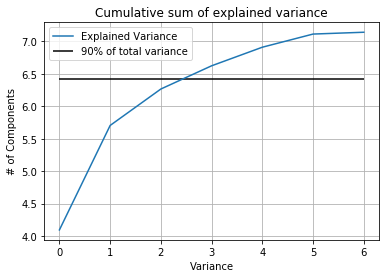

In [156]:
plt.plot(df_27_b.index, df_27_b.cumsum(),label="Explained Variance")

variance_90_percent = df_27_b.cumsum().iat[6,0]*0.9
plt.grid()
plt.hlines(y=variance_90_percent, xmin=0, xmax=6, label="90% of total variance")
plt.ylabel("# of Components")
plt.xlabel("Variance")
plt.title("Cumulative sum of explained variance")
plt.legend()
plt.show()

#### Judging by the plot above, we need at least 4 components to get 90% of the explained variance.

**30) [P] Transform the z_score transformed data using your PCA model (i.e. using the transform function of the
pca object.)**

**(NOTE: I often just store the transformed data temporarily as some arbitrary variable, X, to make it easier to
manipulate the data for plotting.)**

In [162]:
pca_trans = pca.transform(df_car_crashes_zscore)
pca_trans = pd.DataFrame(pca_trans)
pca_trans.head()

,0,1,2,3,4,5,6
0,1.603671,0.133449,0.317881,-0.795293,-0.579719,0.046223,0.210185
1,1.144212,0.858234,0.736626,0.318988,-0.228701,-1.002625,0.008966
2,1.432172,-0.420506,0.338136,0.552513,0.168718,-0.804523,-0.076107
3,2.491584,0.348968,-1.788747,0.264064,-0.372382,-0.481849,-0.147636
4,-1.750638,0.633625,-0.136176,-0.974916,-0.315811,0.178510,-0.068958


**31) [P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label
each point, and label your axes as component 1 and component 2, respectively.**

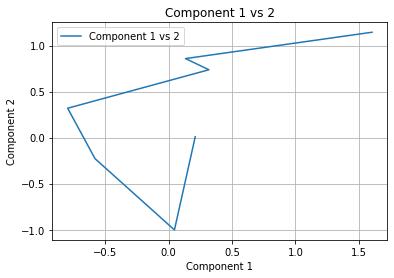

In [164]:
#plt.plot(pca_trans.iloc[:,0], pca_trans.iloc[:,1],label="Component 1 vs 2")
plt.plot(pca_trans.iloc[0,:], pca_trans.iloc[1,:],label="Component 1 vs 2")

plt.grid()
plt.ylabel("Component 2")
plt.xlabel("Component 1")
plt.title("Component 1 vs 2")
plt.legend()
plt.show()

**32) [M] Compare the states you reported as potential outliers above to those that appear to be outliers from your
plot. Do the same results seem to hold?**

#### As far as I can tell the same results hold.

**33) [P] Read how to generate a 3D scatterplot in seaborn or plotly, and use it to generate a scatterplot of the first
3 components.**

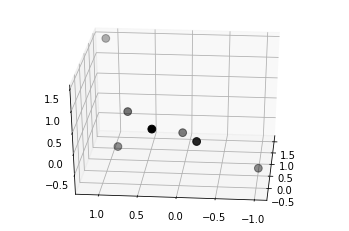

In [179]:
#https://python-graph-gallery.com/370-3d-scatterplot/
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_trans.iloc[0,:], pca_trans.iloc[1,:], pca_trans.iloc[2,:], c='black', s=60)
ax.view_init(30, 185)
plt.show()


**34) [M] Do the same outliers still stand out?**

#### Yes.